## Prerequisites

In [1]:
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.data_utils import load_dataset ,load_file, split_ids
from utils.preprocessing import create_batch_sequences
from utils.evaluate import compare_events
from scipy.signal import find_peaks
np.random.seed(123)

For each valid trial, the relevant data and information are saved in **five** different data files:
- sub-\<label\>_task-\<label\>[_run-\<label\>]_events.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_motion.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_motion.tsv

As we only consinder **walk** trials, we can look for any **_events.tsv** file that contains **_task-walk** in the filename.

## Get data

In [2]:
# Set root directory
ROOT_DIR = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"

# Split subjects into a train, validation, and test set
train_ids, val_ids, test_ids = split_ids(ROOT_DIR, by=["gender", "participant_type"])
print(f"# of subjects in train set:\t{len(train_ids):d}\t{train_ids[:5]}")
print(f"# of subjects in val set:\t{len(val_ids):d}\t{val_ids[:5]}")
print(f"# of subjects in test set:\t{len(test_ids):d}\t{test_ids[:5]}")

# of subjects in train set:	62	['sub-pp147', 'sub-pp039', 'sub-pp135', 'sub-pp157', 'sub-pp106']
# of subjects in val set:	49	['sub-pp047', 'sub-pp153', 'sub-pp168', 'sub-pp125', 'sub-pp010']
# of subjects in test set:	49	['sub-pp156', 'sub-pp155', 'sub-pp167', 'sub-pp126', 'sub-pp165']


In [3]:
# User settings
TRACKED_POINTS = ["left_ankle", "right_ankle", "left_shank", "right_shank"]
INCL_MAGN = False
NORMALIZE = True

In [4]:
# Get datasets
ds_train = load_dataset(ROOT_DIR, sub_ids=train_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)
ds_val = load_dataset(ROOT_DIR, sub_ids=val_ids, tracked_points=TRACKED_POINTS, normalize=NORMALIZE)
ds_test = load_dataset(ROOT_DIR, sub_ids=test_ids, tracked_points=TRACKED_POINTS, normalize=NORMALIZE)

In [5]:
WIN_LEN = 400
STEP_LEN = 200
train_data, train_targets, ds_train_batches = create_batch_sequences(ds_train, win_len=WIN_LEN, step_len=STEP_LEN)
val_data, val_targets, ds_val_batches = create_batch_sequences(ds_val, win_len=WIN_LEN, step_len=STEP_LEN)

## Build model

In [6]:
from tensorflow import keras
from tcn import TCN, tcn_full_summary

In [13]:
NB_FILTERS = 16
KERNEL_SIZE = 5
DILATIONS = [1, 2, 4]
PADDING = "same"

In [11]:
def build_model(input_dim, class_names):
    # Define layers
    inputs = keras.layers.Input(shape=(None, input_dim), name="inputs")
    tcn = TCN(
        nb_filters=NB_FILTERS,
        kernel_size=KERNEL_SIZE,
        dilations=DILATIONS,
        padding=PADDING,
        use_batch_norm=True,
        use_skip_connections=True,
        return_sequences=True,
        name="tcn_layer"
    )(inputs)
    outputs = []
    for i in range(len(class_names)):
        outputs.append(keras.layers.Dense(units=1, activation="sigmoid", name=class_names[i])(tcn))
    
    # Instantiate model
    model = keras.models.Model(inputs=inputs, outputs=outputs, name="tcn_model")

    # Compile
    model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.0003))
    return model

In [14]:
model = build_model(train_data.shape[-1], class_names=list(train_targets.keys()))
model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 6)]    0           []                               
                                                                                                  
 tcn_layer (TCN)                (None, None, 16)     7472        ['inputs[0][0]']                 
                                                                                                  
 initial_contact (Dense)        (None, None, 1)      17          ['tcn_layer[0][0]']              
                                                                                                  
 final_contact (Dense)          (None, None, 1)      17          ['tcn_layer[0][0]']              
                                                                                          

In [15]:
history = model.fit(x=train_data, y=train_targets, batch_size=16, epochs=5, validation_data=(val_data, val_targets))

Epoch 1/5
211/211 [==============================] - 6s 9ms/step - loss: 0.3275 - initial_contact_loss: 0.0307 - final_contact_loss: 0.2968 - val_loss: 0.2887 - val_initial_contact_loss: 0.0301 - val_final_contact_loss: 0.2586
Epoch 2/5
211/211 [==============================] - 2s 8ms/step - loss: 0.1433 - initial_contact_loss: 0.0201 - final_contact_loss: 0.1232 - val_loss: 0.1060 - val_initial_contact_loss: 0.0190 - val_final_contact_loss: 0.0870
Epoch 3/5
211/211 [==============================] - 2s 9ms/step - loss: 0.0804 - initial_contact_loss: 0.0167 - final_contact_loss: 0.0636 - val_loss: 0.0428 - val_initial_contact_loss: 0.0162 - val_final_contact_loss: 0.0266
Epoch 4/5
211/211 [==============================] - 2s 8ms/step - loss: 0.0396 - initial_contact_loss: 0.0142 - final_contact_loss: 0.0254 - val_loss: 0.0326 - val_initial_contact_loss: 0.0141 - val_final_contact_loss: 0.0185
Epoch 5/5
211/211 [==============================] - 2s 8ms/step - loss: 0.0268 - initial_co

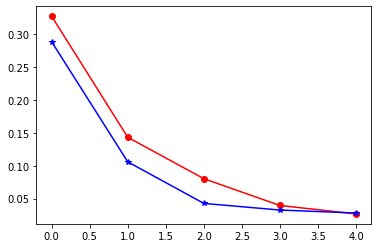

In [16]:
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], 'ro-', label='training')
ax.plot(history.history["val_loss"], 'b*-', label="validation")
plt.show()

### Evaluate on test set

In [9]:
def fancy_plot(ds_test, ix_sub_id, predictions, ix_IC_pred, ix_FC_pred):
    cm = 1/2.54

    fig, axs = plt.subplots(1+len(ds_test[ix_sub_id]["targets"].keys()), 1, figsize=(16*cm, 9*cm), sharex=True, gridspec_kw={"height_ratios": [3, 1, 1]})
    axs[0].plot(np.arange(ds_test[ix_sub_id]["data"].shape[0]), ds_test[ix_sub_id]["data"][:,5], ls="-", c=(0, 0, 0), alpha=0.3)
    axs[0].plot(np.argwhere(ds_test[ix_sub_id]["targets"]["initial_contact"]==1)[:,0], ds_test[ix_sub_id]["data"][np.argwhere(ds_test[ix_sub_id]["targets"]["initial_contact"]==1)[:,0],5], ls="none", marker="o", mfc="none", mec=(0, 0, 1))
    axs[0].plot(np.argwhere(ds_test[ix_sub_id]["targets"]["final_contact"]==1)[:,0], ds_test[ix_sub_id]["data"][np.argwhere(ds_test[ix_sub_id]["targets"]["final_contact"]==1)[:,0],5], ls="none", marker="o", mfc="none", mec=(0, 0.65, 0))
    axs[0].xaxis.set_minor_locator(plt.MultipleLocator(10))
    axs[0].grid(which="both", axis="both", c=(0, 0, 0), alpha=0.1, ls=":")
    axs[0].set_xlim([0, ds_test[ix_sub_id]["data"].shape[0]])

    axs[1].plot(np.arange(ds_test[ix_sub_id]["targets"]["initial_contact"].shape[0]), ds_test[ix_sub_id]["targets"]["initial_contact"][:,0], ls="-", c=(0, 0, 1), lw=2, alpha=0.2)
    axs[1].plot(np.arange(predictions[0][0].shape[0]), predictions[0][0][:,0], ls="-", lw=1, c=(0, 0, 1))
    axs[1].plot(ix_IC_pred, predictions[0][0][ix_IC_pred,0], ls="none", marker="o", mfc="none", mec=(0, 0, 1))
    axs[1].set_ylim([0.1, 1.1])
    axs[1].set_yticks([0, 1])
    axs[1].set_ylabel("Pr(IC)")
    axs[1].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[1].grid(which="both", axis="both", c=(0, 0, 0), alpha=0.1, ls=":")

    axs[2].plot(np.arange(ds_test[ix_sub_id]["targets"]["final_contact"].shape[0]), ds_test[ix_sub_id]["targets"]["final_contact"][:,0], ls="-", c=(0, 0.65, 0), lw=2, alpha=0.2)
    axs[2].plot(np.arange(predictions[1][0].shape[0]), predictions[1][0][:,0], ls="-", lw=1, c=(0, 0.65, 0))
    axs[2].plot(ix_FC_pred, predictions[1][0][ix_FC_pred,0], ls="none", marker="o", mfc="none", mec=(0, 0.65, 0))
    axs[2].set_ylim([0.1, 1.1])
    axs[2].set_yticks([0, 1])
    axs[2].set_ylabel("Pr(FC)")
    axs[2].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[2].grid(which="both", axis="both", c=(0, 0, 0), alpha=0.1, ls=":")
    axs[2].set_xlabel("sample")

    plt.tight_layout()
    plt.savefig(os.path.join("/home/robbin/Desktop/fig/20220222", ds_test[ix_sub_id]["filename_prefix"]+"_"+ds_test[ix_sub_id]["left_or_right"]+"_predictions.png"), dpi=300)
    plt.close()
    return

In [10]:
def add_metrics(ds_test, ix_sub_id, visualize=True):
    # Get data array
    X = ds_test[ix_sub_id]["data"]
    X = np.expand_dims(X, axis=0)
    
    # Predict
    predictions = model.predict(X)
    
    # Get true and predicted events
    ix_IC_true, _ = find_peaks(ds_test[ix_sub_id]["targets"]["initial_contact"][:,0], height=0.4, distance=100)
    ix_FC_true, _ = find_peaks(ds_test[ix_sub_id]["targets"]["final_contact"][:,0], height=0.4, distance=100)
    ix_IC_pred, _ = find_peaks(predictions[0][0][:,0], height=0.4, distance=100)
    ix_FC_pred, _ = find_peaks(predictions[1][0][:,0], height=0.4, distance=100)
    
    event_type, ix_ref, ix_pred = [], [], []
    # Initial contacts
    ann2pred, pred2ann, dt = compare_events(ix_IC_true, ix_IC_pred)
    for i in range(len(ix_IC_true)):
        event_type.append("IC")
        ix_ref.append(ix_IC_true[i])
        if ann2pred[i] > -999:
            # print(f"{ix_IC_true[i]:>6d} : {ix_IC_pred[ann2pred[i]]}")
            ix_pred.append(ix_IC_pred[ann2pred[i]])
        else:
            # print(f"{ix_IC_true[i]:>6d} : {'n/a':s}")
            ix_pred.append("n/a")
    for j in range(len(ix_IC_pred)):
        if pred2ann[j] == -999:
            event_type.append("IC")
            ix_ref.append("n/a")
            ix_pred.append(ix_IC_pred[j])
            # print(f"{'n/a':>6s} : {ix_IC_pred[j]}")
            
    # Final contacts
    ann2pred, pred2ann, dt = compare_events(ix_FC_true, ix_FC_pred)
    for i in range(len(ix_FC_true)):
        event_type.append("FC")
        ix_ref.append(ix_FC_true[i])
        if ann2pred[i] > -999:
            # print(f"{ix_FC_true[i]:>6d} : {ix_FC_pred[ann2pred[i]]}")
            ix_pred.append(ix_FC_pred[ann2pred[i]])
        else:
            # print(f"{ix_FC_true[i]:>6d} : {'n/a':s}")
            ix_pred.append("n/a")
    for j in range(len(ix_FC_pred)):
        if pred2ann[j] == -999:
            event_type.append("FC")
            ix_ref.append("n/a")
            ix_pred.append(ix_FC_pred[j])
            # print(f"{'n/a':>6s} : {ix_FC_pred[j]}")
    
    sub_id = [ds_test[ix_sub_id]["filename_prefix"][4:9] for _ in range(len(event_type))]
    filenames = [ds_test[ix_sub_id]["filename_prefix"] for _ in range(len(event_type))]
    side = [ds_test[ix_sub_id]["left_or_right"] for _ in range(len(event_type))]
    
    # Visualize
    if visualize:
        fancy_plot(ds_test=ds_test, ix_sub_id=ix_sub_id, predictions=predictions, ix_IC_pred=ix_IC_pred, ix_FC_pred=ix_FC_pred)
    
    return sub_id, filenames, side, event_type, ix_ref, ix_pred

In [11]:
sub_ids, filenames, sides, event_types, ix_refs, ix_preds = [], [], [], [], [], []
for i in range(len(ds_test)):
    print(f"{i:>3d}: {ds_test[i]['filename_prefix']+'_'+ds_test[i]['left_or_right']:s}")
    sub_id, filename, side, event_type, ix_ref, ix_pred = add_metrics(ds_test, ix_sub_id=i)
    sub_ids += sub_id
    filenames += filename
    sides += side
    event_types += event_type
    ix_refs += ix_ref
    ix_preds += ix_pred    

  0: sub-pp156_task-walkFast_left
  1: sub-pp156_task-walkFast_right
  2: sub-pp156_task-walkPreferred_left
  3: sub-pp156_task-walkPreferred_right
  4: sub-pp156_task-walkSlow_left
  5: sub-pp156_task-walkSlow_right
  6: sub-pp155_task-walkFast_left
  7: sub-pp155_task-walkFast_right
  8: sub-pp155_task-walkPreferred_left
  9: sub-pp155_task-walkPreferred_right
 10: sub-pp155_task-walkSlow_left
 11: sub-pp155_task-walkSlow_right
 12: sub-pp167_task-walkFast_left
3 gait events annotated, but none were detected
 13: sub-pp167_task-walkFast_right
 14: sub-pp167_task-walkPreferred_left
 15: sub-pp167_task-walkPreferred_right
 16: sub-pp167_task-walkSlow_left
 17: sub-pp167_task-walkSlow_right
 18: sub-pp126_task-walkFast_left
 19: sub-pp126_task-walkFast_right
 20: sub-pp126_task-walkPreferred_left
 21: sub-pp126_task-walkPreferred_right
 22: sub-pp126_task-walkSlow_left
 23: sub-pp126_task-walkSlow_right
 24: sub-pp165_task-walkFast_left
 25: sub-pp165_task-walkFast_right
 26: sub-pp165_

In [12]:
df_out = pd.DataFrame({
    "sub": sub_ids,
    "filename": filenames,
    "side": sides,
    "event_type": event_types,
    "ix_ref": ix_refs,
    "ix_pred": ix_preds
})
df_out.head()

,sub,filename,side,event_type,ix_ref,ix_pred
0,pp156,sub-pp156_task-walkFast,left,IC,139,n/a
1,pp156,sub-pp156_task-walkFast,left,IC,329,n/a
2,pp156,sub-pp156_task-walkFast,left,IC,514,n/a
3,pp156,sub-pp156_task-walkFast,left,IC,700,n/a
4,pp156,sub-pp156_task-walkFast,left,IC,882,881


In [14]:
df_out.to_csv("gait_event_detection.tsv", sep="\t")

In [15]:
len(df_out)

2983